In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.functional import F
from tqdm import tqdm
import pandas as pd

In [2]:
def scotts_factor(n):
    """Compute Scott's factor.
    Returns
    -------
    s : float
        Scott's factor.
    """
    return np.power(n, -1./5)

In [3]:
# Plot data distribution
def plot_dist(data1, data2, col, ax=None):
    if not ax:
        _, ax = plt.subplots(1,1)
        
    ax.hist(data1[col], density=True, fill='black', histtype='stepfilled', 
             edgecolor='black', bins= 20, linewidth=1.2, label=data1.name)
    ax.hist(data2[col], density=True, bins= 20, fill='blue', histtype='stepfilled',
             edgecolor='blue', linewidth=1.2, label=data2.name, alpha=0.7)
    ax.legend(loc='best')
    ax.set_title(col)
    return 

In [4]:
import torch
from torch.distributions import Normal
from torch.distributions.distribution import Distribution

class GaussianKDE(Distribution):
    def __init__(self, X, bw, weights=None):
        """
        X : tensor (n, d)
          `n` points with `d` dimensions to which KDE will be fit
        bw : numeric
          bandwidth for Gaussian kernel
        """
        self.X = X
        self.bw = bw
        self.n = X.shape[0]
        self.mvn = Normal(loc=torch.zeros(1), scale=1)
        
        if weights is not None:
            self.weights = weights/sum(weights)
        else:
            self.weights = (1/len(X))*torch.ones(len(X))
        self.neff = 1/sum(self.weights**2)

    def score_samples(self, Y, X=None):
        """Returns the kernel density estimates of each point in `Y`.

        Parameters
        ----------
        Y : tensor (m, d)
          `m` points with `d` dimensions for which the probability density will
          be calculated
        X : tensor (n, d), optional
          `n` points with `d` dimensions to which KDE will be fit. Provided to
          allow batch calculations in `log_prob`. By default, `X` is None and
          all points used to initialize KernelDensityEstimator are included.


        Returns
        -------
        probs : tensor (m)
          probability densities for each of the queried points in `Y`
        """
        if X == None:
            X = self.X
        
        bw = self.bw
        logprob = (self.mvn.log_prob((X.unsqueeze(1) - Y) / bw))
        
#         probs = ((1/bw) * torch.exp(logprob).sum(dim=0))/self.n
        
        # experiment
        b = self.weights.repeat(Y.shape[0],1).T.unsqueeze(2)
        w = (b * torch.exp(logprob))/sum(self.weights)
        probs = (1/bw)* w.sum(dim=0)
        
        return probs
    
    __call__ = score_samples

In [13]:
class KDEoptim(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self, X, wp):
        
        super().__init__()
        weights = torch.ones(X.shape[0], requires_grad=True)/len(X)  
        self.weights = nn.Parameter(weights)
        self.waypoints = wp
        self.kde_target = GaussianKDE(X, bw=0.2)(wp)
        
    def forward(self, Y):
        """Implement function to be optimised. In this case, an exponential decay
        function (a + exp(-k * X) + b),
        """
        kde2_estimated = GaussianKDE(Y, bw=0.2, weights=self.weights)(self.waypoints)
        return sum(torch.square(self.kde_target - kde2_estimated))
    
def training_loop(model, optimizer, n=50):
    "Training loop for torch model."
    losses = []
    for i in tqdm(range(n)):
        preds = model(Y)
        preds.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(preds) 
        
        with torch.no_grad():
            for param in model.parameters():
                param.clamp_(0, 100)
    
    return losses

In [14]:
waypoints = np.atleast_2d(np.array([9, 9.5, 10, 10.5, 11])).T

torch.manual_seed(42)
X = torch.normal(10, 1, size=(5000, 1))
Y = torch.normal(14, 2.5, size=(5000, 1))

Xdf = pd.DataFrame(X.numpy(), columns=['a'])
Ydf = pd.DataFrame(Y.numpy(), columns=['b'])

In [15]:
# instantiate model
m = KDEoptim(X, waypoints)

# Instantiate optimizer
opt = torch.optim.Adam(m.parameters(), lr=0.001)
losses = training_loop(m, opt)

100%|██████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.25it/s]


In [16]:
optweights = m.weights.detach().numpy()

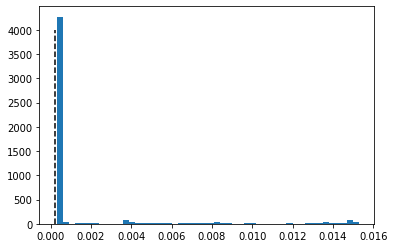

In [21]:
plt.hist(optweights, bins=len(X)//100)
plt.vlines(x=1/len(X), ymin=0, ymax=4000, color='black', linestyles='dashed')

In [22]:
Ydf_study = Ydf.sample(200, replace=True, weights=optweights, random_state=42)

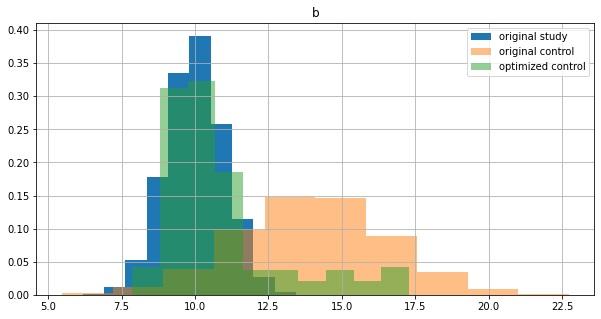

In [23]:
f, ax = plt.subplots(1,1, figsize=(10, 5))

Xdf.hist(ax=ax, label='original study', density=True)
Ydf.hist(ax=ax, label='original control', alpha=0.5, density=True)
Ydf_study.hist(ax=ax, label='optimized control', alpha=0.5, density=True)

plt.legend()